In [75]:
#Amazon yorumları için sentiment analysis ve sentiment modeling uygulayacağız.
#Adımlar:
#Metin Önişleme
#Metin Görselleştirme
#Duygu Analizi (Yada başka analiz)
#Feature Engineering(Eğer makine öğremini uygulayacaksak)
#Modelleme

In [1]:
from warnings import filterwarnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
import nltk

In [2]:
filterwarnings('ignore')
#Maksimum sütun sayısını belirlemedik. Büyük sayıda sütuna sahip bir DataFrame ile çalışırken kırpma yapmadan tüm sütunları görmemizi sağlar.
pd.set_option('display.max_columns', None)
#DataFrame'in her bir satırının içeriğinin yatayda kırpılmadan görüntülenmesini sağlamak için kullanılır.
pd.set_option('display.width', 200)
#virgülden sonra 2 basamak göster
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_csv(r"C:\Users\Senfonico\Desktop\nlp\datasets\amazon_reviews.csv", sep=",")


In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [5]:
df['reviewText']

0                                              No issues.
1       Purchased this for my device, it worked as adv...
2       it works as expected. I should have sprung for...
3       This think has worked out great.Had a diff. br...
4       Bought it with Retail Packaging, arrived legit...
                              ...                        
4910    I bought this Sandisk 16GB Class 10 to use wit...
4911    Used this for extending the capabilities of my...
4912    Great card that is very fast and reliable. It ...
4913    Good amount of space for the stuff I want to d...
4914    I've heard bad things about this 64gb Micro SD...
Name: reviewText, Length: 4915, dtype: object

In [6]:
#Büyük-küçük harfi standardize etmeliyiz. Tüm harfleri küçült.
df['reviewText']=df['reviewText'].str.lower()
df['reviewText']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [7]:
#Sayıları, noktalama işaretlerini, ve dilde yaygın olarak geçen için, bu, gibi ifadeleri(stop words) silmeliyiz. Ama uygulamaya göre burdaki durumlar değişebilir.
#noktalama işaretlerini silelim. (regular exression araştır)
df['reviewText']=df['reviewText'].str.replace('[^\w\s]', '', regex='True')
df['reviewText']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewText, Length: 4915, dtype: object

In [8]:
#sayılardan kurtulalım.
df['reviewText']=df['reviewText'].str.replace('\d', '', regex='True')
df['reviewText']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewText, Length: 4915, dtype: object

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Senfonico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#Yaygın kullanılan kelimeleri çıkar.(Stop words)
sw_en=stopwords.words('english')
sw_en
#Metne gidip her bir satırı gezmek ve tüm kelimelere gitmemiz gerek.
#Satırı boşluklara göre ayırıp varolan stopwords listesinde olmayan kelimeleri birleştirmeliyiz.
# lambda ile x e bağlı bir fonksiyon tanımladık.apply ile geziyoruz ve boşluklara göre ayırdık ve kelime stopwords içerisinde yoksa birleştir.
df['reviewText']=df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw_en))


In [11]:
df['reviewText']

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [12]:
#Nadir kelimeler çalışmada tutmak istemeyiz genelde. ve bunu kendi kontrolümüzde yapmak isteriz.
#bir kelime metinde kaç kere geçmiş onu bulmalıyız.
#Geçici bir dataframe olusturuyoruz.
df_hangikelimekaçtane= pd.Series(' '. join(df['reviewText']).split()).value_counts()
df_hangikelimekaçtane

card          4603
gb            1725
phone         1685
works         1559
great         1445
              ... 
sharper          1
cheapos          1
gate             1
measuring        1
stealwould       1
Name: count, Length: 9701, dtype: int64

In [13]:
#Bir ve birden az olanları seçelim.
drops=df_hangikelimekaçtane[df_hangikelimekaçtane <=1]
drops


conclusionmy       1
mbsbuy             1
flimsier           1
disappointedtry    1
priceokay          1
                  ..
sharper            1
cheapos            1
gate               1
measuring          1
stealwould         1
Name: count, Length: 5612, dtype: int64

In [14]:
#Kelimelerin nerdeyse yarısı nadir kelimeler, bir ölçüm çıkarmayacağını düşünerek uçuruyoruz.
df['reviewText']=df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['reviewText']

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected higher capacity think made bit ...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used capabilities samsung galaxy note greatly ...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [15]:
#Tokenization 
#Cümleleri tokenlarına ayırmak demek cümleleri parçalamak demektir.
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Senfonico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
#Tüm satırlarda gez, texblob metodu çalıştırdıktan sonra kelimeri getir.
df["reviewText"].apply(lambda x: TextBlob(x).words).head()
#Tüm cümleler kendi içerisinde parçalarında ayrıldı.

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [17]:
#Lemmatization
#Kelimeleri köklerine ayırma işlemidir. 
import nltk
nltk.download('omw-1.4')
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Senfonico\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Senfonico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
df["reviewText"]=df["reviewText"].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
df["reviewText"]

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

In [19]:
#Metin Görselleştirme
#Kelimelerin frekanslarını saydırırsak grafik oluşturabiliriz.
#Cümleleri ayır ve frekanslarını topla.
vdf=df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
vdf.columns=["words", "vdf"]
vdf

,words,vdf
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00
...,...,...
3683,pureview,3.00
3684,laptoptablet,2.00
3685,employee,2.00
3686,sandisksequential,2.00


In [20]:
vdf.sort_values("vdf", ascending=False)

,words,vdf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
...,...,...
2721,sizethe,2.00
2719,everybody,2.00
2717,lived,2.00
3687,chkdsk,2.00


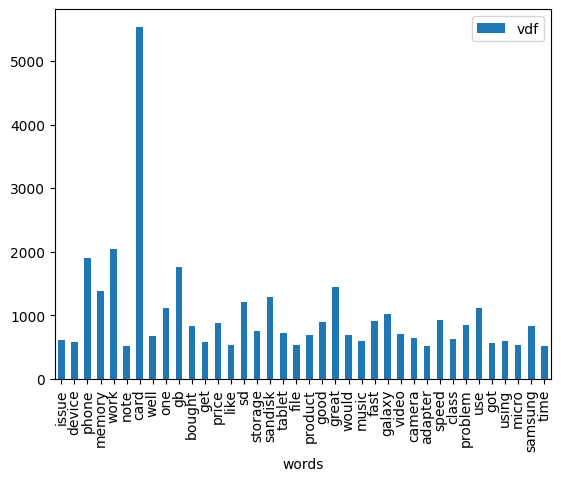

In [21]:
#Kabul edilebilir frekansı belirle ve onları görselleştir.
#500'den fazlasını getir. Grafiğini çiz.
vdf[vdf["vdf"]>500].plot.bar(x="words", y="vdf")
plt.show()
#Ürün ve konunun ne olduğunu bilmeden geldiğimizde ürünün ne olduğu hakkında tahmin yürütebiliriz.
#Çoklu ürünler ile çalıştığımızda en çok hangi konularda şikayet almış onu görebiliriz.
#Düşük puan verenler arasında en fazla kullanılan kelimeleri bulabiliriz.

In [22]:
#WordCloud oluşturalım.
#Tüm yorumları tek bir cümle gibi toplamalıyız.
text=" ".join(i for i in df.reviewText)
text

'issue purchased device worked advertised never much phone memory since download lot stuff brainer work expected higher capacity think made bit earlier version paint look clean think worked gb card went south one held pretty well since note update ive month zero issue since transferred note note card reliable bought retail packaging arrived legit envelope version asian like picture show arrived quickly bought retail packaging htc one lg optimus card working order probably best price youll get nice sd card mini storage doesnt anything else supposed purchased add additional storage microsoft surface pro tablet come gb supposed sandisk long standing reputation speaks phone never skip beat file transfer speedy corruption issue memory issue would expect sandisk brand great card precious file slightly cheaper piece crap lose everything spending extra couple buck trusted product go good qa hard believe affordable digital become gb device one quarter postage stamp would le generation picked po

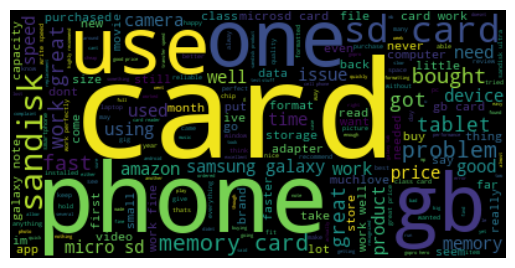

In [23]:
wordcloud= WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#Frekans açısından en yüksek kelimelerin en büyük olduğunu görüyoruz. Dolayısıyla bir kelime bulutundaki kelimelerin büyüklüğü onun frekansıyla alakalı.
#Wordcloud metodunu çalıştırdığımızda bizim yukarda yaptığımız manuel işlemleri bu metod bunu tek başına yapıyo.
#Renkleri ve şekilleri nasıl değiştireceğiz öğrenelim.


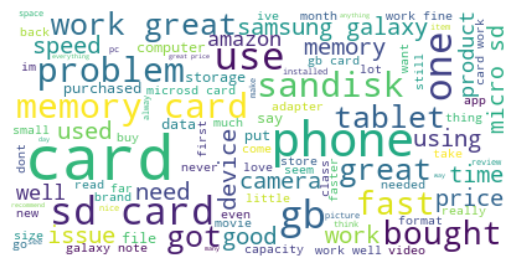

In [24]:
#Daha açık bir plot, fon size 50 olsun ve kelime sayısını filtreleyelim.
wordcloud=WordCloud(max_font_size=50,
                   max_words=100,
                   background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#Kaydetmek istersek
#wordcloud.to_file("wordcloud.png")

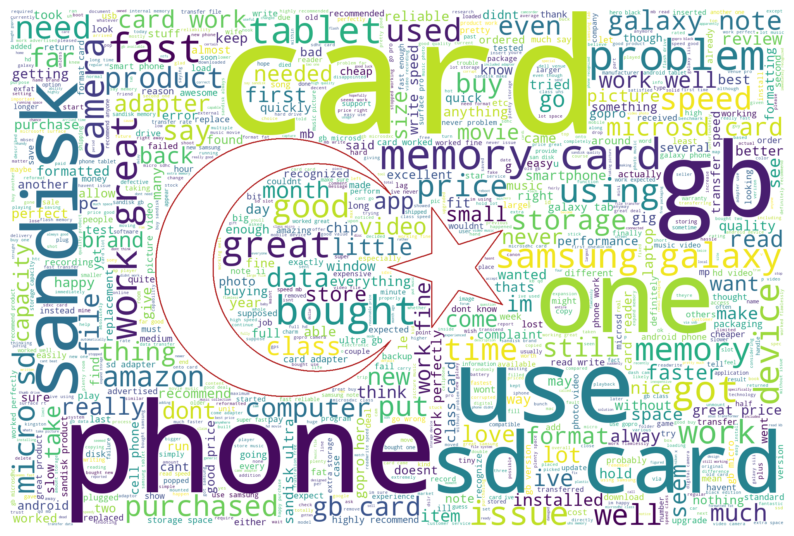

In [25]:
#Şablonlara göre WordCloud olusturalım.
tr_mask = np.array(Image.open("C:\\Users\\Senfonico\\Desktop\\nlp\\tr.png"))

wc=WordCloud(background_color="white",
            max_words=1000,
            mask=tr_mask,
            contour_width=3,
            contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
#Sentiment analizi yapıcaz.
df['reviewText'].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [27]:
#Bi listeye gidiyoruz kelimeyi soruyoruz o bizde pozitif, negaiv ve nötr olduğuna dair bize bi bilgi veriyo.

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Senfonico\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
sam=SentimentIntensityAnalyzer()


In [29]:
#Polarite skoru olusturabiliriz.
# Örnek bir metin üzerinde polarite skoru alın
polarity_score = sam.polarity_scores("The film was awesome")

# Polarite skorunu yazdırın
print(polarity_score)
#Duygu skorları -1 ve 1 arasında değişmektedir. Compound 0 dan büyükse cümle pozitif 0 dan küçükse negatiftir.

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}


In [30]:
sam.polarity_scores("i liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [31]:
#Tüm yorumlarda gezip her bir reviewin duygu durumunu bulmalıyız.
df["polarity_score"]=df['reviewText'].apply(lambda x: sam.polarity_scores(x)["compound"])
df
#polarity scoreler sıfırdan büyük ve verdiği puanlar üçler küçükse çıkarımlarda bulunmaya calısınabilir.
#puanların düşük olduğu ve polaritnin yüksek olduğu durumlara gidilebilir. 
#tezatlıklar ortaya çıkarılabilir.

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",bought sandisk gb class use htc inspire month ...,1.00,Do not waste your money.,1374537600,2013-07-23,503,0,0,0.08
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used capability samsung galaxy note greatly ex...,5.00,Great item!,1377129600,2013-08-22,473,0,0,0.18
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card fast reliable come optional adapter...,5.00,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,0.85
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount space stuff want fit gopro say,5.00,Great little card,1379289600,2013-09-16,448,0,0,0.69


In [32]:
#Sentiment Modeling
#Özellikler mühendisliği
#Metin sınıflandırma modeli yapalım. Yorumlar sorulduğunda pozitif yada negatif olduğunu tahmin etmek istiyorum.
#Daha önce denetimsiz öğrenme ile bir skorlama yaptık. Bunun üzerinden denetimli öğrenmeye gideceğiz. 
#Polarity skoredan bağımlı değişken oluşturacağız. Bu sayede denetimsiz bir problemi denetimli bir probleme dönüştüreceğiz.
#Diyelim bir müşteri verimiz var. Müşterilerimizi kümelere ayıracağız. Premium,middle ve alt sınıf müşteri gibi. Yeni müşteri hangisine aittir bunu nasıl belirlerim?
#Elimizdeki müşterilerin denetimsiz öğrenim ile sınıflarını belirledik. Ama yenü müşteri geldikçe baştan bi sınıflandırma işlemi mi yapacağız?
#Bu noktada denetimsiz öğrenme sonucu bulduğumuz değerleri bu kümeler ilgili gözlem bilimlerine label olarak atanır. 
#Elimizde çeşitli hücrelere ait verileri segmentlere bölmek istiyoruz ve yeni bir hücre görüntüsü geldiğinde segmentini belirlemek istiyoruz. Bu noktada ilk önce denetimsiz bir segment çalışması yapılır. Sonrasında labellanır ve denetimli öğrenmeye geçilir.

#Madem belirli bir değerin üzerinde olanları pozitif, altındakileri negatif sınıf olarak işaretleyelim ve sonrasında bu yokmuş gibi sınıflandırma problemi olarak bunu ele alalım.

In [33]:
#Yeni bir değişken oluşturacağız. Positive ve negative gibi.

df['reviewText'][0:10].apply(lambda x: "pos" if sam.polarity_scores(x)["compound"] > 0 else "neg")


0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [34]:
df["sentiment_label"] = df['reviewText'].apply(lambda x: "pos" if sam.polarity_scores(x)["compound"] > 0 else "neg")


In [35]:
df


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",bought sandisk gb class use htc inspire month ...,1.00,Do not waste your money.,1374537600,2013-07-23,503,0,0,0.08,pos
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used capability samsung galaxy note greatly ex...,5.00,Great item!,1377129600,2013-08-22,473,0,0,0.18,pos
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card fast reliable come optional adapter...,5.00,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,0.85,pos
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount space stuff want fit gopro say,5.00,Great little card,1379289600,2013-09-16,448,0,0,0.69,pos


In [36]:
#Kaç negatif ve kaç pozitif yorum var?
df["sentiment_label"].value_counts()

sentiment_label
pos    3944
neg     971
Name: count, dtype: int64

In [37]:
#Sentiment label pozitiflerin puanlarının ortalaması kaçtır?
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.09
pos   4.71
Name: overall, dtype: float64

In [38]:
#string değerleri sayısal değerlere dönüştürmeliyiz.
df["sentiment_label"]= LabelEncoder().fit_transform(df["sentiment_label"])
df["sentiment_label"]
#0 negatif, 1 pozitif oldu. Makine öğrenimi modellerin anlayabilmesi için bunu yaptık.

0       0
1       0
2       1
3       1
4       1
       ..
4910    1
4911    1
4912    1
4913    1
4914    1
Name: sentiment_label, Length: 4915, dtype: int32

In [39]:
#Bağımlı değişken y, bağımsız değişken x. (ama x str değerinde nasıl bunu dönüştüreceğiz? NPL'nin en önemli bölümü.)
y=df["sentiment_label"]
X=df["reviewText"]

In [40]:
#Kelimelerin vektörleşmesi
#Count vector yöntemi (frekans temsiller) (Kelimeleri mi, karakterleri mi yoksa ngramları mı sayacağız)
#ngram, kelimelerin birlikte kullanım kombinasyonlarını gösterir.
#a="""Bu örneği anlaşılması için daha uzun bir metin üzerinden göstereceğim.
#N-gramlar birlikte kullanılan kelimelerin kombinasyonlarını gösterir ve feature üretmek için kullanılır"""
#TextBlob(a).ngrams(3)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
#Kelimeler vector count
#corpus=['This is the first document.',
#        'This document is the second document.',
#        'And this is the third one.',
#        'Is this the first document?']
#vectorizer=CountVectorizer()
#X_c=vectorizer.fit_transform(corpus)
#vectorizer.get_feature_names_out()

In [43]:
#X_c.toarray()
#Bütün veriye tek bir metinmiş gibi yaklaşıp tüm metin içerisindeki eşsiz kelimeleri çıkartıyoruz.


In [44]:
#ngram'a göre olusturalım.
#vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
#X_n=vectorizer2.fit_transform(corpus)
#vectorizer2.get_feature_names_out()

In [45]:
#X_n.toarray()


In [76]:
vectorizer=CountVectorizer()
X_count=vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()

array(['ability', 'able', 'absolute', ..., 'zoom', 'zte', 'zune'],
      dtype=object)

In [77]:
X_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
#TF-IDF
#Count vector yönteminin yanlılıklarını gidermek adına standartlaştırılmış bir kelime vktörü oluşturm yöntemi.
#Kelimelerin dökümanlarda geçme ve cümlelerde geçme sıklığına göre standartlaştırır.
#1. adım count vector heaplanır.
#2. adım TF term frekansı hesaplanır. Her yorumda kaç kelime var/ yorumdaki toplam kelime sayısı.
#3. adım IDF adımı. (1+loge((toplam döküman sayısı+1)/(içinde t terim olan döküman sayısı+1))
#4. Adım TF*IDF
#5. Adım L2 Normalizasyonu yap (Satırların karelerini toplamının karekökünü bul, ilgili satırdaki tüm hücreleri bulduğun değere böl.)


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
#word
tfid_vectorizer_word = TfidfVectorizer()
X_tfid_vectorizer_word = tfid_vectorizer.fit_transform(X)



In [53]:
#ngram
tfid_vectorizer_ngram = TfidfVectorizer(ngram_range=(2,3))
X_tfid_vectorizer_ngram = tfid_vectorizer_ngram.fit_transform(X)

In [57]:
#Modelleme
#Logistic Regression Sınıflandır yöntemi için kullanılır.
log_model= LogisticRegression().fit(X_tfid_vectorizer_word, y)
cross_val_score(log_model,
                X_tfid_vectorizer_word,
                y, 
                scoring="accuracy",
                cv=5).mean()

0.830111902339776

In [65]:
new_review = pd.Series("This product is great")
new_review = pd.Series("look at that shit very bad")
new_review = pd.Series("it was good but i am sure that it fits me")

In [66]:
new_review = TfidfVectorizer().fit(X).transform(new_review)

In [67]:
log_model.predict(new_review)


array([1])

In [69]:
random_review= pd.Series(df["reviewText"].sample(1).values)
random_review

0    even meet specification speed great product in...
dtype: object

In [70]:
new_review = TfidfVectorizer().fit(X).transform(random_review)

In [71]:
log_model.predict(new_review)


array([1])

In [78]:
#Random Forest Regression
#Count vector
rf_model = RandomForestClassifier().fit(X_count, y )
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8408952187182097

In [79]:
#TFID
rf_model = RandomForestClassifier().fit(X_tfid_vectorizer_word, y )
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8408952187182095

In [75]:
#TFID ngram
rf_model = RandomForestClassifier().fit(X_tfid_vectorizer_ngram, y )
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8433367243133265

In [80]:
#Hiperparametre optimizasyonu

rf_model=RandomForestClassifier(random_state=17)

In [82]:
rf_params = {"max_depth": [8,None],
             "max_features": [7,"auto"],
             "min_samples_split": [2,5,8],
             "n_estimators": [100,200]}

In [86]:
rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [87]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [90]:
rf_final=rf_model.set_params(**rf_best_grid.best_params_,random_state=17).fit(X_count, y)

In [91]:
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

0.8130213631739572